Now we will complexify the MLP architecture we have been using so far. We will take more characters as input, and we won't feed them together into a single hidden layer (because it squashes information too quickly), rather we will make a deeper model that progressively fuses this information to make its guess about the next character in the sequence. By doing so, we will basically arrive at the [WaveNet](https://arxiv.org/abs/1609.03499) architecture.
- WaveNet is also a language model basically, but it tries to predict audio sequences instead of character/word sequences.

The largest bottleneck of the current model is that it squashes all information from the characters into a single layer at the very beginning of the forward pass. It doesn't make sense to squash information so quickly. In WaveNet, the per-character information is slowly fused into a global representation, iteratively, in a hierarchical fashion. We fuse bi-gram information first, then we fuse every pair of those as well, and we continue until we arrive at a single representation. Let's implement this.

In [25]:
import torch
from torch import Tensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

from karpathy_nn.makemore.data.load_data import load_names


In [26]:
random.seed(42)
_ = torch.manual_seed(42)


In [27]:
# Read in all the words
words = load_names()
print(len(words))
print(max(len(word) for word in words))
print(words[:8])


32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [28]:
# Build the vocabuilary of characters and mappings to/from integers
characters = sorted(list(set("".join(words))))
string_to_integer = {string: integer + 1 for integer, string in enumerate(characters)}
string_to_integer["."] = 0
integer_to_string = {integer: string for string, integer in string_to_integer.items()}
num_tokens = len(integer_to_string)
print(integer_to_string)
print(num_tokens)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [29]:
# Shuffle the words
random.shuffle(words)


In [30]:
# Build the dataset
block_size = (
    8  # Context length: how many characters do we take to predict the next one?
)


def build_dataset(words: list[str]) -> tuple[Tensor, Tensor]:
    X, Y = [], []

    for word in words:
        context = [0] * block_size
        for character in word + ".":
            idx = string_to_integer[character]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx]  # Crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])  # 10%


torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [31]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(
        "".join(integer_to_string[idx.item()] for idx in x),
        "-->",
        integer_to_string[y.item()],
    )


........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [46]:
# Near copy paste of the layers we have developed in Part 3
# We're basically reimplementing torch.nn.
# Going forward, we'll use torch.nn directly.

# Be careful with the torch documentation, it's often incorrect.

# Always prototype models in a jupyter notebook to make sure that
# the shapes and the implementation is correct. Once we make
# sure everything is correct, we can take that code, scale it up,
# and train on a cluster from VSCode, for example. Andrej does that.

# -----------------------------------------------------------------------------------------------
class Linear:
    def __init__(self, fan_in: int, fan_out: int, bias: bool = True) -> None:
        self.weight = (
            torch.randn((fan_in, fan_out)) / fan_in**0.5
        )  # note: kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x: Tensor) -> Tensor:
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self) -> list[Tensor]:
        return [self.weight] + ([] if self.bias is None else [self.bias])


# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
    def __init__(self, dim: int, eps: float = 1e-5, momentum: float = 0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # Parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # Buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x: Tensor) -> Tensor:
        # Calculate the forward pass
        if self.training:  # Forgetting this flag leads to a lot of bugs
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                # BUG previously: we only flattened with dim = 0
                # for a 3D input. The running mean was
                # (1, 4, hidden_dim) instead of just
                # (1, hidden_dim)! We were maintaining
                # statistics for all 4 positions independently.
                # We want to average over all of them.
                # The vanilla BatchNorm1d can't do this exactly.
                # We expect (N, C) or (N, L, C).
                # It expects (N, C) or (N, C, L).
                # We expect the network to perform a tiny bit better
                # after the bugfix, because now we estimate a single
                # mean, std from more samples.
                dim = (0, 1)

            # For a 3D input, this is (1, 1, dim_hidden).
            # For a 2D input, this is (1, dim_hidden).
            xmean = x.mean(dim, keepdim=True)  # Batch mean
            xvar = x.var(dim, keepdim=True)  # Batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # Normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # Update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * xmean
                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self) -> list[Tensor]:
        return [self.gamma, self.beta]


# -----------------------------------------------------------------------------------------------
class Tanh:
    def __call__(self, x: Tensor) -> Tensor:
        self.out = torch.tanh(x)
        return self.out

    def parameters(self) -> list[Tensor]:
        return []


# -----------------------------------------------------------------------------------------------
class Embedding:  # Also in PyTorch
    def __init__(self, num_embeddings: int, embedding_dim: int) -> None:
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, idx: Tensor) -> Tensor:
        self.out = self.weight[idx]
        return self.out

    def parameters(self) -> list[Tensor]:
        return [self.weight]


# -----------------------------------------------------------------------------------------------
# n = 2
# [1] [2] [3] [4] [5] [6] [7] [8]
# [1 2] [3 4] [5 6] [7 8]  # Process in parallel
# [1 2 3 4] [5 6 7 8]
# [1 2 3 4 5 6 7 8]

# (32, 8, 10) -> (32, 4, 20)

# One way:
# torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)

# Other, equivalent way:
# e.view(32, 4, 20)

class FlattenConsecutive:
    def __init__(self, n: int) -> None:
        self.n = n

    def __call__(self, x: Tensor) -> Tensor:
        B, T, C = x.shape
        x = x.view(B, T // self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self) -> list[Tensor]:
        return []


# -----------------------------------------------------------------------------------------------
class Sequential:
    def __init__(self, layers: list) -> None:
        self.layers = layers

    def __call__(self, x: Tensor) -> Tensor:
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self) -> list[Tensor]:
        # Get parameters of all layers and stretch them out into one list
        return [parameter for layer in self.layers for parameter in layer.parameters()]


In [33]:
# Original network
# dim_embedding = 10  # Dimensionality of the character embedding vectors
# dim_hidden = 300  # Number of neurons in the hidden layer of the MLP
# model = Sequential([
#   Embedding(vocab_size, dim_embedding),
#   FlattenConsecutive(8),
#   Linear(dim_embedding * 8, dim_hidden, bias=False),
#   BatchNorm1d(dim_hidden),
#   Tanh(),
#   Linear(dim_hidden, vocab_size),
# ])

# hierarchical network
dim_embedding = 24  # the dimensionality of the character embedding vectors
dim_hidden = 128  # the number of neurons in the hidden layer of the MLP
model = Sequential(
    [
        Embedding(num_tokens, dim_embedding),
        FlattenConsecutive(2),
        Linear(dim_embedding * 2, dim_hidden, bias=False),
        BatchNorm1d(dim_hidden),
        Tanh(),
        FlattenConsecutive(2),
        Linear(dim_hidden * 2, dim_hidden, bias=False),
        BatchNorm1d(dim_hidden),
        Tanh(),
        FlattenConsecutive(2),
        Linear(dim_hidden * 2, dim_hidden, bias=False),
        BatchNorm1d(dim_hidden),
        Tanh(),
        Linear(dim_hidden, num_tokens),
    ]
)

# Parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1  # Make last layer less confident

parameters = model.parameters()
print(
    sum(parameter.nelement() for parameter in parameters)
)  # Total number of parameters
for parameter in parameters:
    parameter.requires_grad = True


76579


In [34]:
idx = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[idx], Ytr[idx]
logits = model(Xb)
print(Xb.shape)

torch.Size([4, 8])


In [35]:
for layer in model.layers:
    print(f"{layer.__class__.__name__:<20} | {tuple(layer.out.shape)}")

Embedding            | (4, 8, 24)
FlattenConsecutive   | (4, 4, 48)
Linear               | (4, 4, 128)
BatchNorm1d          | (4, 4, 128)
Tanh                 | (4, 4, 128)
FlattenConsecutive   | (4, 2, 256)
Linear               | (4, 2, 128)
BatchNorm1d          | (4, 2, 128)
Tanh                 | (4, 2, 128)
FlattenConsecutive   | (4, 256)
Linear               | (4, 128)
BatchNorm1d          | (4, 128)
Tanh                 | (4, 128)
Linear               | (4, 27)


This is nearly the exact same architecture used in the WaveNet paper, expect they have a total receptive field of size 16, whereas we only have one with size 8.

In [36]:
# Same optimization as last time
max_steps = 200000
batch_size = 32
loss_i = []
val_loss_i = []
val_epoch_i = []

for i in range(max_steps):
    # Construct mini-batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]  # Batch X, Y

    # Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)  # Loss function

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    if i % 1000 == 0:
        with torch.no_grad():
            val_logits = model(Xdev)
            val_loss = F.cross_entropy(val_logits, Ydev)
            val_loss_i.append(val_loss.log10().item())
            val_epoch_i.append(i)

    # Update: simple SGD
    lr = 0.1 if i < 150000 else 0.01  # Step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    loss_i.append(loss.log10().item())


      0/ 200000: 3.3162
  10000/ 200000: 2.0234
  20000/ 200000: 1.9302
  30000/ 200000: 2.7243
  40000/ 200000: 2.1421
  50000/ 200000: 1.8537
  60000/ 200000: 2.1315
  70000/ 200000: 1.8840
  80000/ 200000: 1.8958
  90000/ 200000: 1.9638
 100000/ 200000: 1.7545
 110000/ 200000: 1.9990
 120000/ 200000: 1.7177
 130000/ 200000: 1.9992
 140000/ 200000: 1.7734
 150000/ 200000: 1.7973
 160000/ 200000: 1.9006
 170000/ 200000: 1.6530
 180000/ 200000: 1.5361
 190000/ 200000: 2.0740


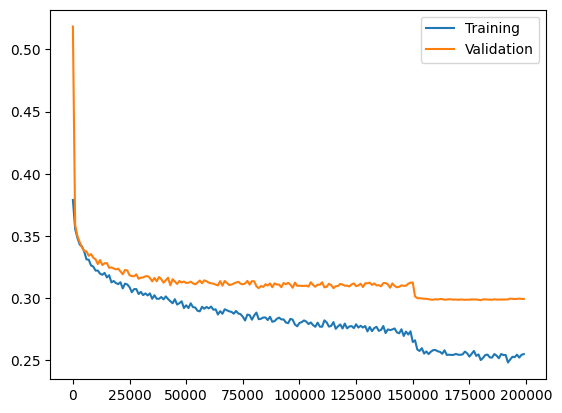

In [44]:
# As we have a batch size of 32, the individual batch losses are simply
# too noisy to see any progress. Instead, we can take the mean of every
# 1000 mini-batch losses (32000 samples) to get a much more stable loss
# value that we can see changing throughout training.
plt.plot(torch.arange(0, 200000, 1000), torch.tensor(loss_i).view(-1, 1000).mean(dim=1), label="Training")
plt.plot(val_epoch_i, val_loss_i, label="Validation")
_ = plt.legend()

At the learning rate decay, we can see a steep decrease in loss. It subtracts a ton of energy out of the system, and allows it to settle into the local minimum of the optimization.

In [38]:
# Put layers into eval mode (needed for BatchNorm especially,
# other layers are unaffected).
for layer in model.layers:
    layer.training = False


In [39]:
# Evaluate the loss
@torch.no_grad()  # Disables gradient tracking inside pytorch
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")


train 1.768236517906189
val 1.9918807744979858


Performance log
- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
- context: 3 -> 8 (22K params): train 1.918, val 2.027
- flat -> hierarchical (22K params): train 1.941, val 2.029
- fix bug in batchnorm: train 1.912, val 2.022
- scale up the network: dim_embedding 24, dim_hidden 128 (76K params): train 1.769, val 1.993

We are quite in the dark regarding the hyperparameter choice, because we have to wait a long time for the network to train, so experiments take longer. In practice, we would want to train the network in parallel with many settings and choose the best one, while looking at performance plots during and after training. We're missing an "experimental harness" here, on which we could run a number of experiments and tune the architecture well.

Note that we didn't implement the specific forward pass of the WaveNet where we have a more complicated linear layer (a gated one) and residual connections, using efficient dilated convolutions.

#### Next time

How does what we've done here relate to ConvNets, as used in the WaveNet paper? The use of conolvutions is strictly for efficiency. It doesn't change the model we have implemented. Brief preview/hint:

In [40]:

for x,y in zip(Xtr[7:15], Ytr[7:15]):
  print(''.join(integer_to_string[ix.item()] for ix in x), '-->', integer_to_string[y.item()])

........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .


In [41]:
# Forward a single example:
logits = model(Xtr[[7]])  # Extra batch dimension: (1, 8)
logits.shape

torch.Size([1, 27])

In [42]:
# Forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
  logits[i] = model(Xtr[[7+i]])
logits.shape

torch.Size([8, 27])

Convolutions allow us to do just that, but more efficiently. Instead of needing 8 independent calls to our model, convolutions allow us to slide our model efficiently through the input sequence. The for loop can be done not inside in Python, but rather inside a cuda kernel, which is much more efficient. The for loop is hidden inside the convolution. It's even more efficient because it allows us to reuse variables that we have calculated before. The naive for loop doesn't allow us to do that.

A convolution is a for loop. It allows us to forward Linear layers (filters) efficiently over the space (input sequence). Now we slide our model over a 1D input data. We've implemented the forward pass for a single position in the input sequence, so to speak. Convolutions slide this computation over the entire input sequence, by first calculating the first hidden layer with dilation 1, then the second one with dilation 2, etc. (see the paper).